In [319]:
# Importing libraries 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime as dt

In [321]:
# Improting dataset as dataframe
df = pd.read_csv('cleaned_activities.csv') #read in csv
df.columns=df.columns.str.lower() #change columns to lower case

In [323]:
# Quick look at the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 94 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   activity id                   113 non-null    int64  
 1   activity date                 113 non-null    object 
 2   activity name                 113 non-null    object 
 3   activity type                 113 non-null    object 
 4   activity description          63 non-null     object 
 5   elapsed time                  113 non-null    float64
 6   distance                      113 non-null    float64
 7   max heart rate                106 non-null    float64
 8   relative effort               106 non-null    float64
 9   commute                       113 non-null    float64
 10  activity private note         0 non-null      float64
 11  activity gear                 0 non-null      float64
 12  filename                      113 non-null    object 
 13  athle

In [325]:
# Since there are 94 columns, let's create a new dataframe only with columns meaningful for the analysis
cols = ['activity id', 'activity date', 'activity type', 'elapsed time',  'distance',   
         'average heart rate', 'moving time', 'max speed', 'average speed', 'calories', 'total steps'
       ]
df = df[cols] 
df

,activity id,activity date,activity type,elapsed time,distance,average heart rate,moving time,max speed,average speed,calories,total steps
0,11343747416,"Apr 28, 2024, 1:31:04 PM",Run,1802.0,2994.610107,125.876801,1802.0,3.008002,1.661826,150.0,3726.0
1,11343747602,"Apr 25, 2024, 1:47:37 PM",Run,1802.0,3048.739990,125.785240,1802.0,3.204000,1.691865,162.0,3712.0
2,11343747698,"Apr 23, 2024, 2:01:57 PM",Run,1808.0,3080.899902,121.413620,1807.0,4.126000,1.704981,165.0,3736.0
3,11343748218,"Apr 22, 2024, 2:53:39 PM",Run,1573.0,2629.350098,120.675346,1573.0,4.214000,1.671551,135.0,3276.0
4,11350539733,"May 6, 2024, 6:37:06 PM",Run,1807.0,3044.459961,136.065857,1807.0,3.063334,1.684815,176.0,3812.0
...,...,...,...,...,...,...,...,...,...,...,...
108,13238980874,"Jan 1, 2025, 12:27:43 PM",Hike,8736.0,7320.799805,120.595985,7323.0,2.083333,0.999700,614.0,11496.0
109,13246771812,"Jan 2, 2025, 7:32:55 AM",Hike,25332.0,21089.199219,124.722160,19987.0,2.400000,1.055146,1847.0,27352.0
110,13264552469,"Jan 4, 2025, 10:10:43 AM",Walk,15974.0,14266.000000,113.464172,13811.0,2.633333,1.032945,1014.0,19076.0
111,13271445921,"Jan 5, 2025, 10:33:11 AM",Workout,3040.0,0.000000,101.244736,3040.0,0.000000,0.000000,178.0,NaN


In [327]:
# The analysis concenrs only runs, so let's create a new dataframe
runs = df[df['activity type']=='Run']
runs = runs.copy()

In [329]:
# Breaking the activity date columns into time and date columns
runs['activity date'] = pd.to_datetime(runs['activity date'])
runs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 0 to 105
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   activity id         70 non-null     int64         
 1   activity date       70 non-null     datetime64[ns]
 2   activity type       70 non-null     object        
 3   elapsed time        70 non-null     float64       
 4   distance            70 non-null     float64       
 5   average heart rate  69 non-null     float64       
 6   moving time         70 non-null     float64       
 7   max speed           70 non-null     float64       
 8   average speed       70 non-null     float64       
 9   calories            38 non-null     float64       
 10  total steps         70 non-null     float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 6.6+ KB


C:\Users\Karol\AppData\Local\Temp\ipykernel_2704\287213698.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  runs['activity date'] = pd.to_datetime(runs['activity date'])


In [331]:
runs.loc[:, 'day'] = runs['activity date'].dt.day
runs.loc[:, 'month_name'] = runs['activity date'].dt.month_name()
runs.loc[:, 'year'] = runs['activity date'].dt.year
runs.loc[:, 'time'] = runs['activity date'].dt.time
runs.head()

,activity id,activity date,activity type,elapsed time,distance,average heart rate,moving time,max speed,average speed,calories,total steps,day,month_name,year,time
0,11343747416,2024-04-28 13:31:04,Run,1802.0,2994.610107,125.876801,1802.0,3.008002,1.661826,150.0,3726.0,28,April,2024,13:31:04
1,11343747602,2024-04-25 13:47:37,Run,1802.0,3048.739990,125.785240,1802.0,3.204000,1.691865,162.0,3712.0,25,April,2024,13:47:37
2,11343747698,2024-04-23 14:01:57,Run,1808.0,3080.899902,121.413620,1807.0,4.126000,1.704981,165.0,3736.0,23,April,2024,14:01:57
3,11343748218,2024-04-22 14:53:39,Run,1573.0,2629.350098,120.675346,1573.0,4.214000,1.671551,135.0,3276.0,22,April,2024,14:53:39
4,11350539733,2024-05-06 18:37:06,Run,1807.0,3044.459961,136.065857,1807.0,3.063334,1.684815,176.0,3812.0,6,May,2024,18:37:06


In [333]:
# Changing year, day and activity date to object 
runs['year'] = (runs['year']).astype(object) 
runs['day'] = (runs['day']).astype(object) 
runs['activity date'] = (runs['activity date']).astype(object) 
runs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 0 to 105
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   activity id         70 non-null     int64  
 1   activity date       70 non-null     object 
 2   activity type       70 non-null     object 
 3   elapsed time        70 non-null     float64
 4   distance            70 non-null     float64
 5   average heart rate  69 non-null     float64
 6   moving time         70 non-null     float64
 7   max speed           70 non-null     float64
 8   average speed       70 non-null     float64
 9   calories            38 non-null     float64
 10  total steps         70 non-null     float64
 11  day                 70 non-null     object 
 12  month_name          70 non-null     object 
 13  year                70 non-null     object 
 14  time                70 non-null     object 
dtypes: float64(8), int64(1), object(6)
memory usage: 8.8+ KB


In [335]:
# At this point I have noticed that I have many missing entries in the calories column, so I dropped it
runs = runs.drop('calories', axis=1)
runs

,activity id,activity date,activity type,elapsed time,distance,average heart rate,moving time,max speed,average speed,total steps,day,month_name,year,time
0,11343747416,2024-04-28 13:31:04,Run,1802.0,2994.610107,125.876801,1802.0,3.008002,1.661826,3726.0,28,April,2024,13:31:04
1,11343747602,2024-04-25 13:47:37,Run,1802.0,3048.739990,125.785240,1802.0,3.204000,1.691865,3712.0,25,April,2024,13:47:37
2,11343747698,2024-04-23 14:01:57,Run,1808.0,3080.899902,121.413620,1807.0,4.126000,1.704981,3736.0,23,April,2024,14:01:57
3,11343748218,2024-04-22 14:53:39,Run,1573.0,2629.350098,120.675346,1573.0,4.214000,1.671551,3276.0,22,April,2024,14:53:39
4,11350539733,2024-05-06 18:37:06,Run,1807.0,3044.459961,136.065857,1807.0,3.063334,1.684815,3812.0,6,May,2024,18:37:06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,13106993425,2024-12-13 12:30:44,Run,3684.0,8009.799805,139.294891,3567.0,3.000000,2.245528,10022.0,13,December,2024,12:30:44
98,13142164721,2024-12-18 13:35:43,Run,2224.0,5769.100098,160.333176,2163.0,3.480000,2.667175,6074.0,18,December,2024,13:35:43
100,13155682056,2024-12-20 14:13:05,Run,4714.0,9998.700195,144.215073,4496.0,3.980000,2.223910,12372.0,20,December,2024,14:13:05
103,13174752942,2024-12-23 13:30:37,Run,2864.0,6981.299805,165.954468,2462.0,4.320000,2.835621,6956.0,23,December,2024,13:30:37


In [337]:
# Converting distance from meters to km, elapsed time and moving time to minutes
runs['distance'] = runs['distance']/1000
runs['elapsed time'] = runs['elapsed time']/60
runs['moving time'] = runs['moving time']/60
runs

,activity id,activity date,activity type,elapsed time,distance,average heart rate,moving time,max speed,average speed,total steps,day,month_name,year,time
0,11343747416,2024-04-28 13:31:04,Run,30.033333,2.99461,125.876801,30.033333,3.008002,1.661826,3726.0,28,April,2024,13:31:04
1,11343747602,2024-04-25 13:47:37,Run,30.033333,3.04874,125.785240,30.033333,3.204000,1.691865,3712.0,25,April,2024,13:47:37
2,11343747698,2024-04-23 14:01:57,Run,30.133333,3.08090,121.413620,30.116667,4.126000,1.704981,3736.0,23,April,2024,14:01:57
3,11343748218,2024-04-22 14:53:39,Run,26.216667,2.62935,120.675346,26.216667,4.214000,1.671551,3276.0,22,April,2024,14:53:39
4,11350539733,2024-05-06 18:37:06,Run,30.116667,3.04446,136.065857,30.116667,3.063334,1.684815,3812.0,6,May,2024,18:37:06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,13106993425,2024-12-13 12:30:44,Run,61.400000,8.00980,139.294891,59.450000,3.000000,2.245528,10022.0,13,December,2024,12:30:44
98,13142164721,2024-12-18 13:35:43,Run,37.066667,5.76910,160.333176,36.050000,3.480000,2.667175,6074.0,18,December,2024,13:35:43
100,13155682056,2024-12-20 14:13:05,Run,78.566667,9.99870,144.215073,74.933333,3.980000,2.223910,12372.0,20,December,2024,14:13:05
103,13174752942,2024-12-23 13:30:37,Run,47.733333,6.98130,165.954468,41.033333,4.320000,2.835621,6956.0,23,December,2024,13:30:37


In [339]:
# Creating an average pace column
runs['avg pace'] = runs['elapsed time'] / runs['distance']
runs

,activity id,activity date,activity type,elapsed time,distance,average heart rate,moving time,max speed,average speed,total steps,day,month_name,year,time,avg pace
0,11343747416,2024-04-28 13:31:04,Run,30.033333,2.99461,125.876801,30.033333,3.008002,1.661826,3726.0,28,April,2024,13:31:04,10.029130
1,11343747602,2024-04-25 13:47:37,Run,30.033333,3.04874,125.785240,30.033333,3.204000,1.691865,3712.0,25,April,2024,13:47:37,9.851064
2,11343747698,2024-04-23 14:01:57,Run,30.133333,3.08090,121.413620,30.116667,4.126000,1.704981,3736.0,23,April,2024,14:01:57,9.780692
3,11343748218,2024-04-22 14:53:39,Run,26.216667,2.62935,120.675346,26.216667,4.214000,1.671551,3276.0,22,April,2024,14:53:39,9.970778
4,11350539733,2024-05-06 18:37:06,Run,30.116667,3.04446,136.065857,30.116667,3.063334,1.684815,3812.0,6,May,2024,18:37:06,9.892285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,13106993425,2024-12-13 12:30:44,Run,61.400000,8.00980,139.294891,59.450000,3.000000,2.245528,10022.0,13,December,2024,12:30:44,7.665610
98,13142164721,2024-12-18 13:35:43,Run,37.066667,5.76910,160.333176,36.050000,3.480000,2.667175,6074.0,18,December,2024,13:35:43,6.425034
100,13155682056,2024-12-20 14:13:05,Run,78.566667,9.99870,144.215073,74.933333,3.980000,2.223910,12372.0,20,December,2024,14:13:05,7.857688
103,13174752942,2024-12-23 13:30:37,Run,47.733333,6.98130,165.954468,41.033333,4.320000,2.835621,6956.0,23,December,2024,13:30:37,6.837313


In [341]:
# Let's take a look at the summary of our dataframe (excluding the id column)
runs.iloc[:, 1:].describe().round(0)

,elapsed time,distance,average heart rate,moving time,max speed,average speed,total steps,avg pace
count,70.0,70.0,69.0,70.0,70.0,70.0,70.0,70.0
mean,38.0,5.0,141.0,37.0,4.0,2.0,5813.0,8.0
std,11.0,2.0,9.0,10.0,0.0,0.0,1828.0,1.0
min,26.0,3.0,121.0,26.0,3.0,2.0,3276.0,6.0
25%,30.0,4.0,134.0,30.0,3.0,2.0,4476.0,7.0
50%,36.0,5.0,143.0,34.0,3.0,2.0,5620.0,8.0
75%,43.0,5.0,148.0,39.0,4.0,2.0,6476.0,9.0
max,79.0,10.0,166.0,75.0,5.0,3.0,12372.0,15.0


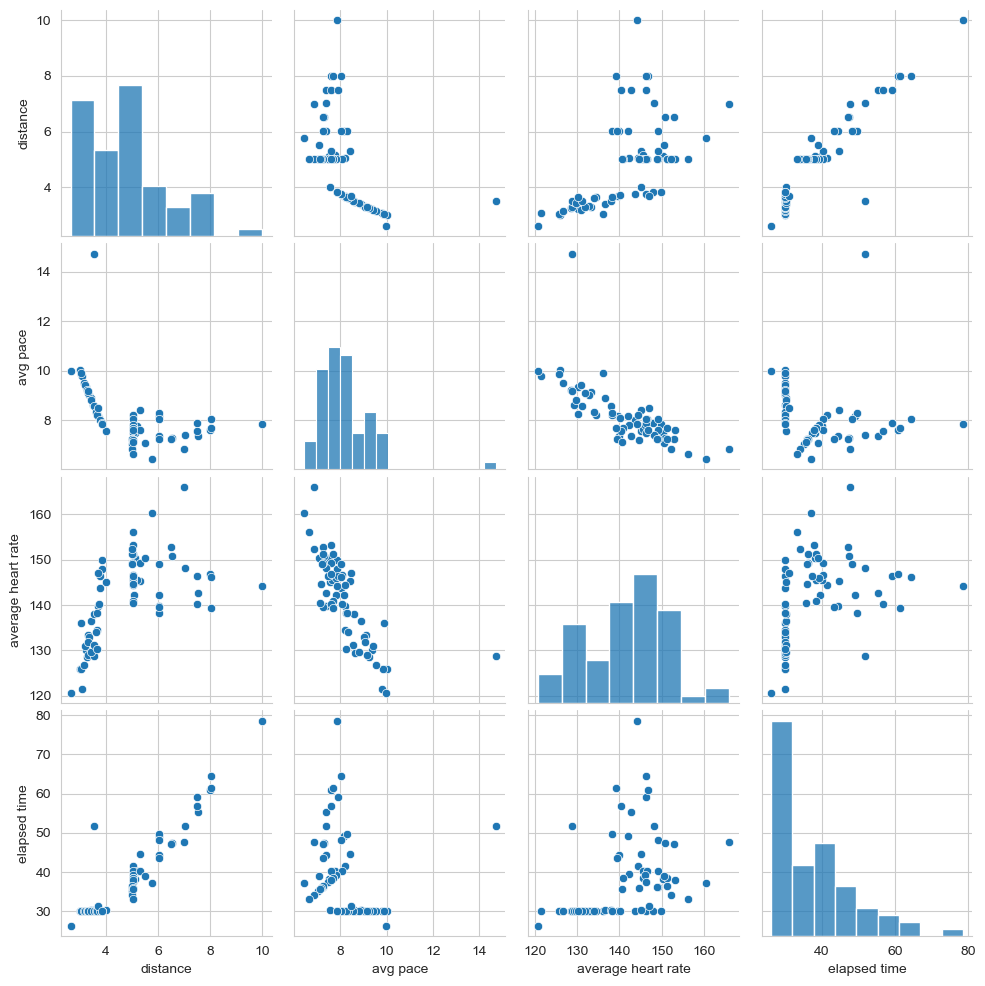

In [343]:
# Let's create a paris plot using the seaborn library to identify trends. I picked only few varabiales so that it won't get messy.
pp_runs = runs[['distance', 'avg pace', 'average heart rate', 'elapsed time']]
sns.pairplot(pp_runs)

# The histograms shows us the distribution of a single variable and the scatter plots depict the relationship between two variables. 
# In the distance histogram I can see that most of my runs are rather short (up to 5 km on average).
# It's also noticable, that there is a negative correlation between average heart rate and average pace.  

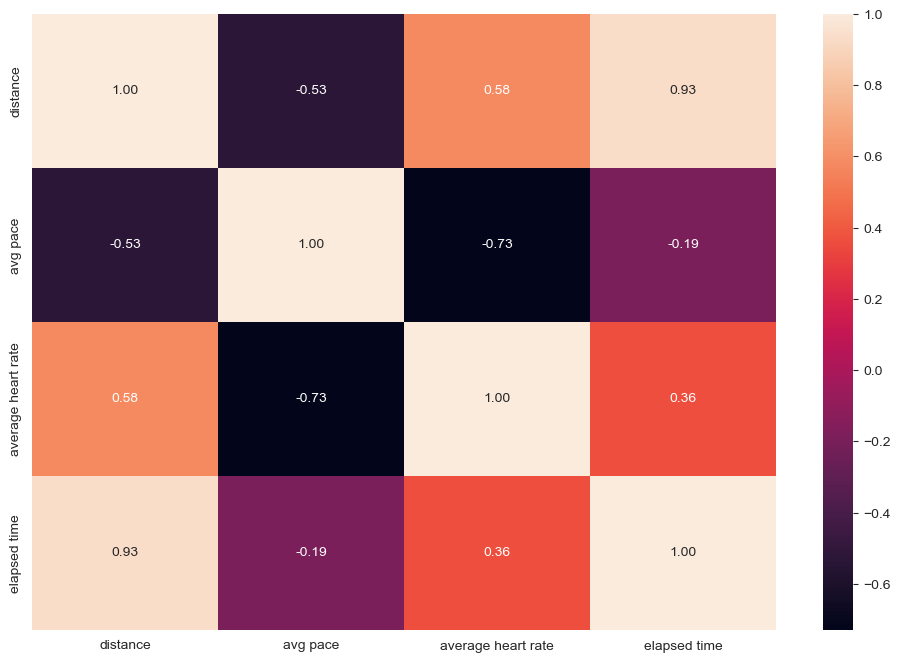

In [344]:
# We can also create a heatmap to see what is the exact correlation between chosen variables
corr = pp_runs.corr()
plt.figure(figsize = (12,8))
sns.heatmap(corr, annot=True, fmt=".2f");

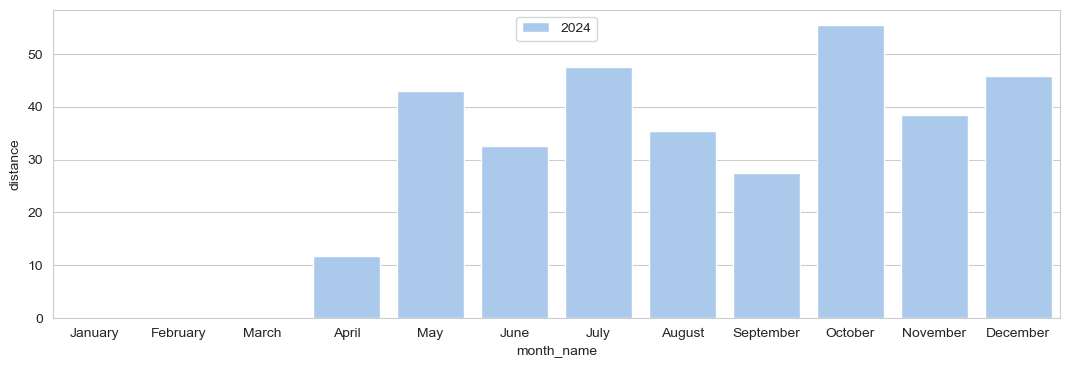

In [345]:
# Let's create a bar plot using seaborn library to see how the distance changed throught the year

sns.set_style('whitegrid')
sns.barplot(x='month_name', y='distance', data=runs, hue='year', errorbar=None, estimator=np.sum, palette = "pastel",
           order =["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])
plt.gcf().set_size_inches(13, 4)
plt.legend(loc='upper center')

# In April the total distance is really small comparing to other months, but the first entry in the dataset is from end of April. 
# It seems that the distance I ran in October 2024 was the highest of all months. 